# IOE 511 / MATH 562 Optimization Project

## Experiment Runner and Visualization


In [1]:
import numpy as np
import matplotlib.pyplot as plt
import time
import pandas as pd
import os

import problems
import solver

print("Modules imported.")

Modules imported.


## 1. Define Problems and Methods

Define the set of problems and optimization methods to compare.

In [2]:
# List of problem names to test
problem_names = [
    'quad_10_10',
    'quad_10_1000',
    'quad_1000_10',
    'quad_1000_1000',
    'quartic_1',
    'quartic_2',
    'rosenbrock',
    'powell',
    'genhumps_5',
    'ill_conditioned_10_6'
]

# Load problems
# Note: Ensure .mat files for quadratic problems are accessible (e.g., in the same directory)
test_problems = []
missing_files = False
for name in problem_names:
    try:
        # The get_problem function handles loading .mat files internally now
        problem_obj = problems.get_problem(name)
        test_problems.append(problem_obj.to_dict()) # Convert to dict for solver
    except FileNotFoundError as e:
        print(f"Warning: Could not load problem '{name}'. {e}. Skipping.")
        missing_files = True
    except Exception as e:
        print(f"Warning: Error loading problem '{name}': {e}. Skipping.")
        missing_files = True

if missing_files:
    print("\nEnsure the .mat files for quadratic problems are in the correct directory.")

# List of methods to test (using names expected by solver.py)
method_specs = [
    {'name': 'GradientDescent'},     # Backtracking 
    {'name': 'GradientDescentW'},    # Wolfe
    {'name': 'Newton'},              # Backtracking 
    {'name': 'NewtonW'},             # Wolfe 
    {'name': 'BFGS'},                # Backtracking 
    {'name': 'BFGSW'},               # Wolfe 
    {'name': 'DFP'},                 # Backtracking 
    {'name': 'DFPW'},                # Wolfe
    {'name': 'TRNewtonCG'},          # Trust Region Newton CG 
    {'name': 'TRSR1CG'},             # Trust Region SR1 CG 
    # L-BFGS Variants - Add memory size and strategy 
    {'name': 'LBFGS-M5-FIFO'},
    {'name': 'LBFGS-M5-MIN_CURV'},
    {'name': 'LBFGS-M5-ADAPTIVE'},
    {'name': 'LBFGS-M10-FIFO'},
    {'name': 'LBFGS-M10-MIN_CURV'},
    {'name': 'LBFGS-M10-ADAPTIVE'}
]

print(f"Loaded {len(test_problems)} problems.")
print(f"Defined {len(method_specs)} methods.")

Loaded 10 problems.
Defined 16 methods.


## 2. Define Options and Run Experiments

Set common optimization options and run the solver for each problem-method pair.

In [3]:
# Define common options [cite: 278, 299]
options = {
    'term_tol': 1e-6,
    'max_iterations': 1000,
    'verbose': False # Set to True for detailed iteration output
    # Add other options like c1_ls, c2_ls, delta_init if needed
}

# Store results
results = {}
detailed_info = {} # Store the full info dict for analysis

for problem in test_problems:
    problem_name = problem['name']
    print(f"\n--- Solving Problem: {problem_name} ---")
    results[problem_name] = {}
    detailed_info[problem_name] = {}
    
    for method in method_specs:
        method_name = method['name']
        print(f"  Using Method: {method_name}...")
        
        # Make a deep copy of options to avoid modification across runs if needed
        current_options = options.copy()
        
        # Make a copy of the problem dict to potentially reset x0 if necessary
        problem_instance = problem.copy()
        problem_instance['x0'] = problem['x0'].copy() # Ensure x0 is reset
        
        start_run_time = time.time()
        try:
            import algorithms # Need to import here if calling directly
            import copy
            
            if method_name == "GradientDescent":
                x_final, f_final, info = algorithms.gradient_descent(problem_instance, current_options, backtracking=True)
            elif method_name == "GradientDescentW":
                x_final, f_final, info = algorithms.gradient_descent(problem_instance, current_options, backtracking=False)
            elif method_name == "Newton":
                x_final, f_final, info = algorithms.newton(problem_instance, current_options, backtracking=True)
            elif method_name == "NewtonW":
                x_final, f_final, info = algorithms.newton(problem_instance, current_options, backtracking=False)
            elif method_name == "BFGS":
                x_final, f_final, info = algorithms.bfgs(problem_instance, current_options, backtracking=True)
            elif method_name == "BFGSW":
                x_final, f_final, info = algorithms.bfgs(problem_instance, current_options, backtracking=False)
            elif method_name == "DFP":
                x_final, f_final, info = algorithms.dfp(problem_instance, current_options, backtracking=True)
            elif method_name == "DFPW":
                x_final, f_final, info = algorithms.dfp(problem_instance, current_options, backtracking=False)
            elif method_name == "TRNewtonCG":
                x_final, f_final, info = algorithms.trust_region_newton(problem_instance, current_options)
            elif method_name == "TRSR1CG":
                x_final, f_final, info = algorithms.trust_region_sr1(problem_instance, current_options)
            elif method_name.startswith("LBFGS"):
                 parts = method_name.split('-')
                 memory_size = int(parts[1][1:]) if len(parts) > 1 else 5
                 strategy_name = parts[2].upper() if len(parts) > 2 else "FIFO"
                 strategy = algorithms.RemovalStrategy[strategy_name] if strategy_name in algorithms.RemovalStrategy.__members__ else algorithms.RemovalStrategy.FIFO
                 backtracking = not ('W' in method_name)
                 x_final, f_final, info = algorithms.run_lbfgs_with_strategy(
                    problem_instance, current_options, memory_size, strategy, backtracking)
            else:
                 raise ValueError(f"Method {method_name} direct call not implemented here.")
            
            end_run_time = time.time()
            run_time = end_run_time - start_run_time
            
            # --- Store Summary Results (for table) --- 
            results[problem_name][method_name] = {
                'Iterations': info['iterations'],
                'Final f(x)': f_final,
                'Final ||∇f(x)||': info['grad_norms'][-1] if info['grad_norms'] else 'N/A',
                'CPU Time (s)': run_time, # Use actual measured time
                'Success': info['success'],
                'Termination': info['termination_reason']
            }
            # Store full info for plotting
            detailed_info[problem_name][method_name] = info 
            print(f"    Finished in {run_time:.4f} s, Iterations: {info['iterations']}, Success: {info['success']}")
            
        except Exception as e:
            print(f"    Failed: {e}")
            results[problem_name][method_name] = {
                'Iterations': 'Fail',
                'Final f(x)': 'Fail',
                'Final ||∇f(x)||': 'Fail',
                'CPU Time (s)': 'Fail',
                'Success': False,
                'Termination': str(e)
            }
            detailed_info[problem_name][method_name] = {'success': False, 'termination_reason': str(e)}
            



--- Solving Problem: quad_10_10 ---
  Using Method: GradientDescent...
    Finished in 0.0030 s, Iterations: 120, Success: True
  Using Method: GradientDescentW...
    Finished in 0.0010 s, Iterations: 120, Success: True
  Using Method: Newton...
    Finished in 0.0005 s, Iterations: 1, Success: True
  Using Method: NewtonW...
    Finished in 0.0000 s, Iterations: 1, Success: True
  Using Method: BFGS...
    Finished in 0.0010 s, Iterations: 27, Success: True
  Using Method: BFGSW...
    Finished in 0.0010 s, Iterations: 27, Success: True
  Using Method: DFP...
    Finished in 0.0005 s, Iterations: 42, Success: True
  Using Method: DFPW...
    Finished in 0.0010 s, Iterations: 42, Success: True
  Using Method: TRNewtonCG...
    Finished in 0.0355 s, Iterations: 1000, Success: False
  Using Method: TRSR1CG...
    Finished in 0.0200 s, Iterations: 377, Success: True
  Using Method: LBFGS-M5-FIFO...
    Finished in 0.0010 s, Iterations: 22, Success: True
  Using Method: LBFGS-M5-MIN_CURV

## 3. Results Summary Table

Display the summary results in a table as requested.

In [4]:
# --- Create Summary Table --- 
summary_data = []
method_names_list = [m['name'] for m in method_specs]

for prob_name in results:
    for meth_name in method_names_list:
        if meth_name in results[prob_name]:
            res = results[prob_name][meth_name]
            # Format results for display
            iter_disp = res['Iterations']
            f_disp = f"{res['Final f(x)']:.4e}" if isinstance(res['Final f(x)'], (int, float)) else 'Fail'
            norm_disp = f"{res['Final ||∇f(x)||']:.4e}" if isinstance(res['Final ||∇f(x)||'], (int, float)) else 'Fail'
            time_disp = f"{res['CPU Time (s)']:.4f}" if isinstance(res['CPU Time (s)'], (int, float)) else 'Fail'
            success_disp = 'Yes' if res['Success'] else 'No'
            
            summary_data.append({
                'Problem': prob_name,
                'Method': meth_name,
                'Iterations': iter_disp,
                'Final f(x)': f_disp,
                'Final ||∇f(x)||': norm_disp,
                'CPU Time (s)': time_disp,
                'Success': success_disp
            })
        else:
             # Handle cases where a method might not have results for a problem
             summary_data.append({
                'Problem': prob_name,
                'Method': meth_name,
                'Iterations': 'N/A',
                'Final f(x)': 'N/A',
                'Final ||∇f(x)||': 'N/A',
                'CPU Time (s)': 'N/A',
                'Success': 'N/A'
            })

# Create DataFrame for better display
# Ensure display is imported if running outside a standard Jupyter environment
try:
    from IPython.display import display
except ImportError:
    display = print # Fallback to print if display is not available
summary_df = pd.DataFrame(summary_data)
summary_df.set_index(['Problem', 'Method'], inplace=True)

# Display the table
print("--- Summary of Results ---")
display(summary_df)

--- Summary of Results ---


Iterations   Final f(x)  \
Problem             Method                                        
quad_10_10          GradientDescent            120  -2.4709e+01   
                    GradientDescentW           120  -2.4709e+01   
                    Newton                       1  -2.4709e+01   
                    NewtonW                      1  -2.4709e+01   
                    BFGS                        27  -2.4709e+01   
...                                            ...          ...   
IllConditioned_10_6 LBFGS-M5-MIN_CURV         1000  -3.2225e-01   
                    LBFGS-M5-ADAPTIVE         1000  -3.1339e-01   
                    LBFGS-M10-FIFO            1000  -3.2325e-01   
                    LBFGS-M10-MIN_CURV        1000  -3.2325e-01   
                    LBFGS-M10-ADAPTIVE        1000  -3.2325e-01   

                                       Final ||∇f(x)|| CPU Time (s) Success  
Problem             Method                                                   
quad_10_10          GradientDescent         9.0912e-07       0.0030     Yes  
                    GradientDescentW        9.0912e-07       0.0010     Yes  
                    Newton                  2.8475e-16       0.0005     Yes  
                    NewtonW                 2.8475e-16       0.0000     Yes  
                    BFGS                    3.2647e-07       0.0010     Yes  
...                                                ...          ...     ...  
IllConditioned_10_6 LBFGS-M5-MIN_CURV       1.2887e+00       0.0250      No  
                    LBFGS-M5-ADAPTIVE       1.9368e+01       0.0355      No  
                    LBFGS-M10-FIFO          6.4948e-04       0.3941      No  
                    LBFGS-M10-MIN_CURV      6.4948e-04       0.4180      No  
                    LBFGS-M10-ADAPTIVE      1.6351e-03       0.1930      No  

[160 rows x 5 columns]

In [5]:
print("\nUnique values in Problem level:", summary_df.index.get_level_values('Problem').unique())
print("\nUnique values in Method level:", summary_df.index.get_level_values('Method').unique())


Unique values in Problem level: Index(['quad_10_10', 'quad_10_1000', 'quad_1000_10', 'quad_1000_1000',
       'quartic_1', 'quartic_2', 'Rosenbrock', 'Powell', 'genhumps_5',
       'IllConditioned_10_6'],
      dtype='object', name='Problem')

Unique values in Method level: Index(['GradientDescent', 'GradientDescentW', 'Newton', 'NewtonW', 'BFGS',
       'BFGSW', 'DFP', 'DFPW', 'TRNewtonCG', 'TRSR1CG', 'LBFGS-M5-FIFO',
       'LBFGS-M5-MIN_CURV', 'LBFGS-M5-ADAPTIVE', 'LBFGS-M10-FIFO',
       'LBFGS-M10-MIN_CURV', 'LBFGS-M10-ADAPTIVE'],
      dtype='object', name='Method')


In [9]:
summary_df.loc['genhumps_5']

,Iterations,Final f(x),Final ||∇f(x)||,CPU Time (s),Success
Method,,,,,
GradientDescent,214,4.3429e-12,9.3198e-07,0.0055,Yes
GradientDescentW,230,4.4389e-12,9.4222e-07,0.0080,Yes
Newton,69,3.2987e-19,2.6501e-10,0.0420,Yes
NewtonW,1000,1.0249e+05,1.9207e+02,1.2479,No
BFGS,44,3.5374e-14,1.1564e-07,0.0020,Yes
BFGSW,90,1.3076e-13,1.8046e-07,0.0055,Yes
DFP,1000,3.4521e+00,1.7700e+00,0.0390,No
DFPW,1000,8.4563e-01,6.7875e-01,0.0420,No
TRNewtonCG,170,1.4563e-14,5.3968e-08,0.0860,Yes


In [10]:
summary_df.loc['IllConditioned_10_6']

,Iterations,Final f(x),Final ||∇f(x)||,CPU Time (s),Success
Method,,,,,
GradientDescent,1000,6.3249e+01,2.4482e+02,0.0725,No
GradientDescentW,1000,5.7795e+05,6.5104e+05,0.5419,No
Newton,1,-3.2325e-01,1.4683e-10,0.0005,Yes
NewtonW,1,-3.2325e-01,1.4683e-10,0.0005,Yes
BFGS,27,-3.2325e-01,2.5139e-09,0.0095,Yes
BFGSW,1000,5.7795e+05,6.5104e+05,1.1375,No
DFP,17,-3.2325e-01,4.8377e-09,0.0015,Yes
DFPW,1000,5.7795e+05,6.5104e+05,1.1536,No
TRNewtonCG,41,-3.2325e-01,6.6151e-07,0.0025,Yes


## 4. Performance Visualization

Plot convergence graphs and performance profiles.

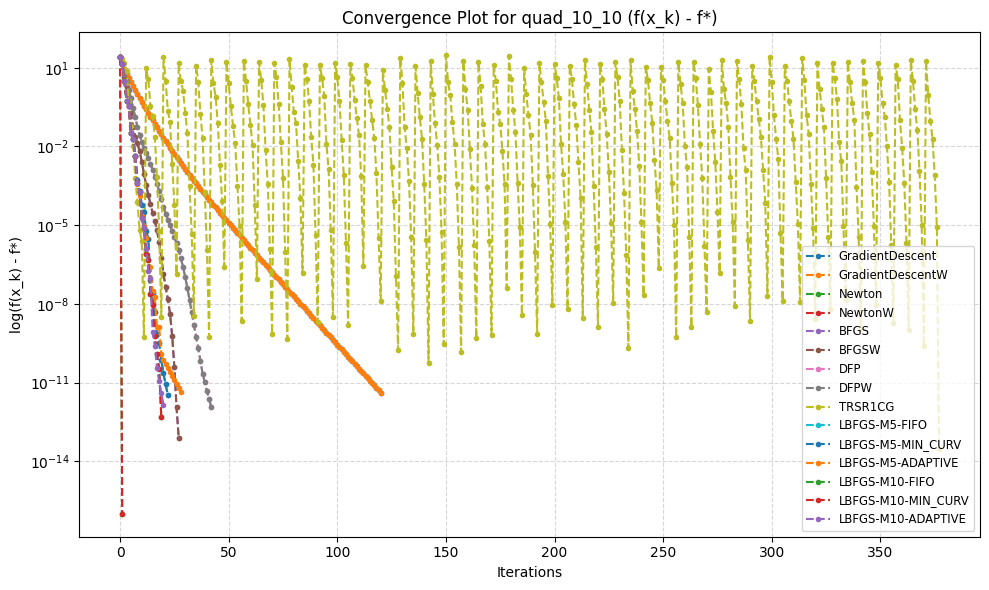

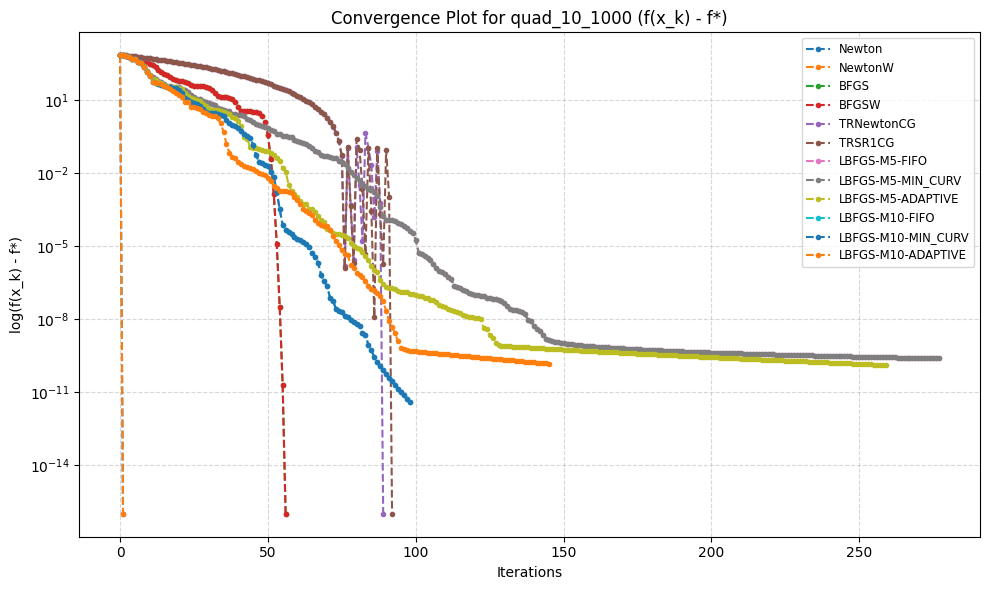

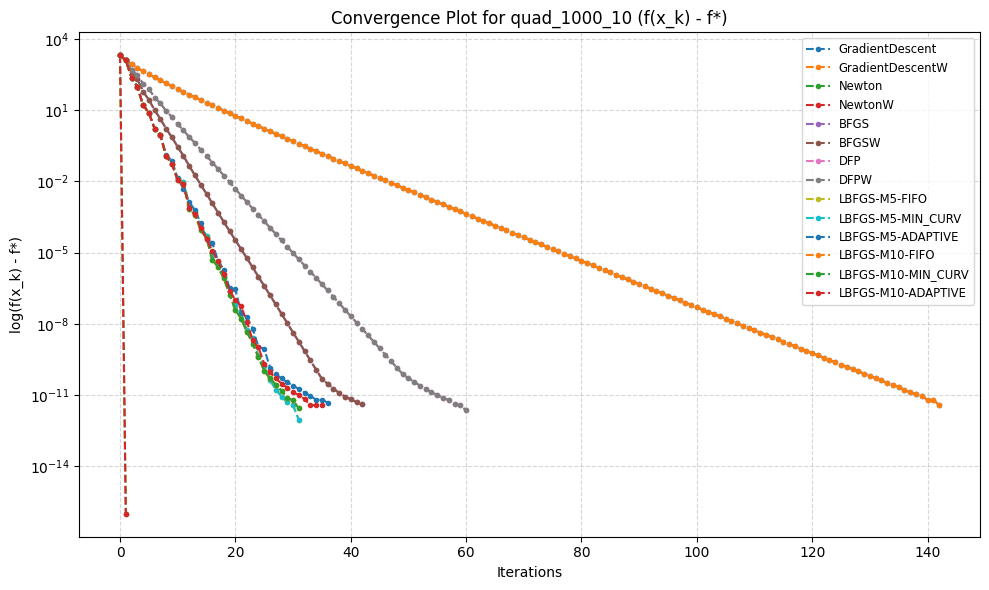

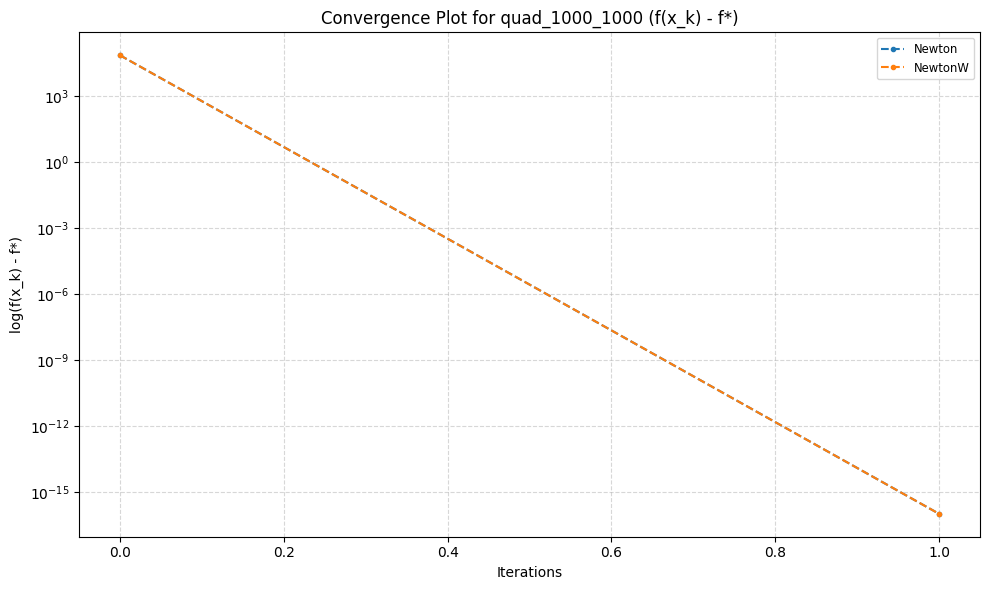

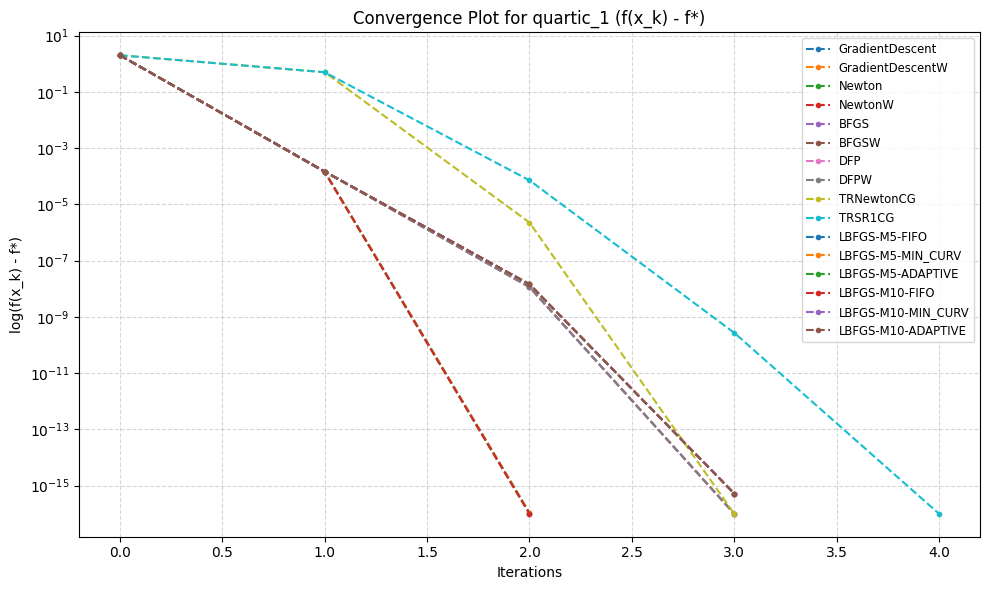

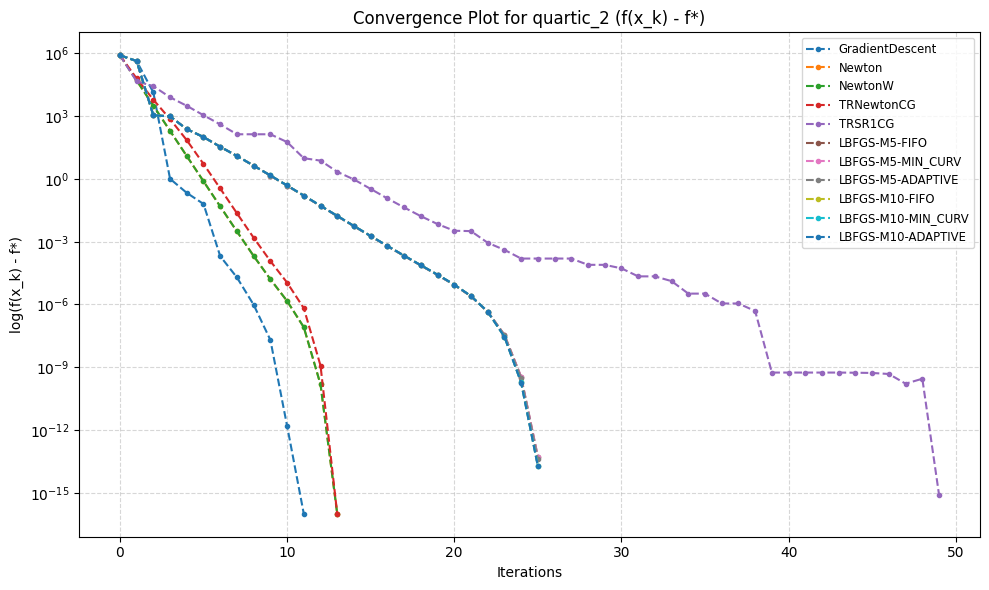

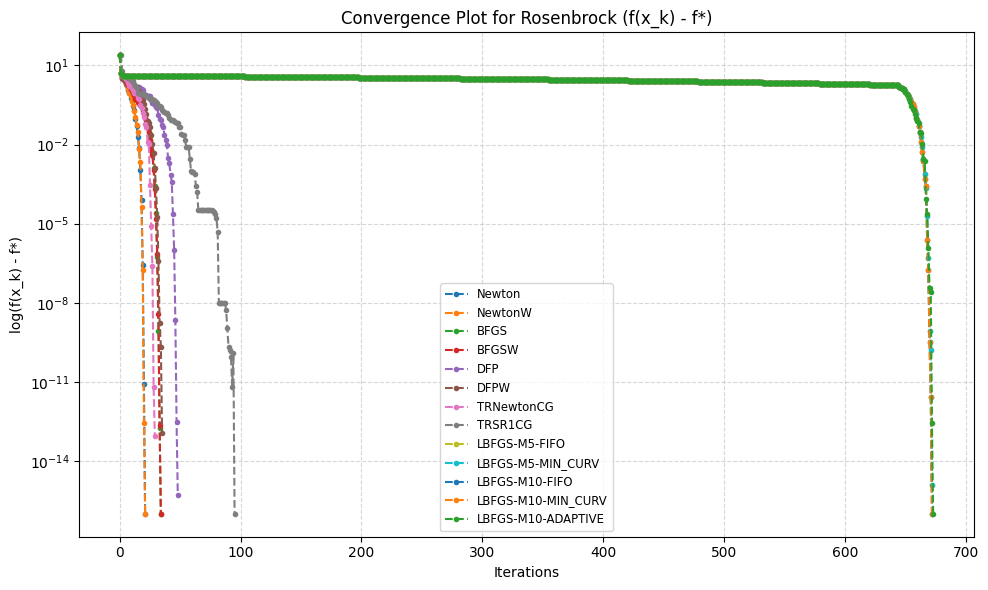

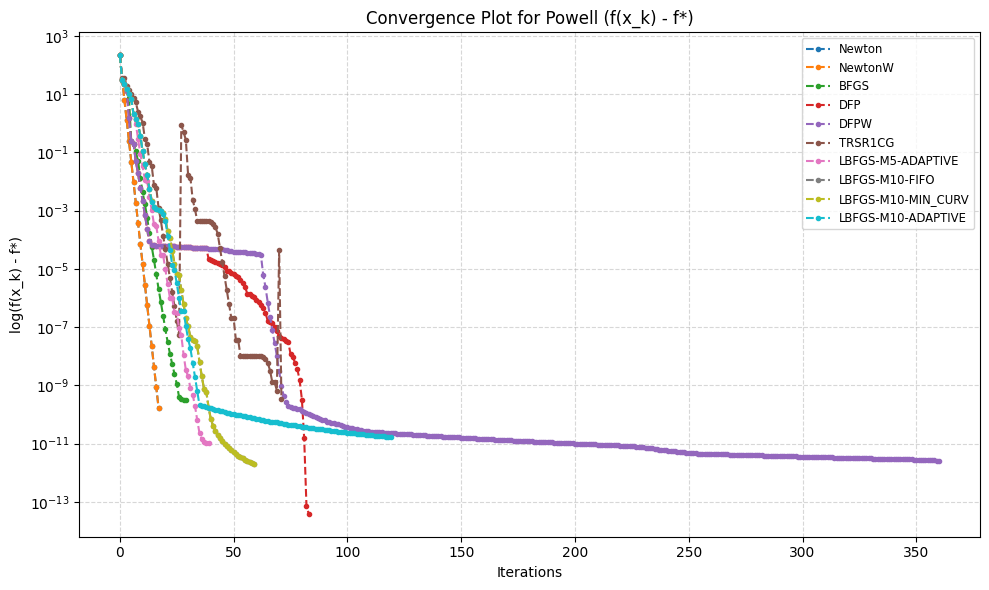

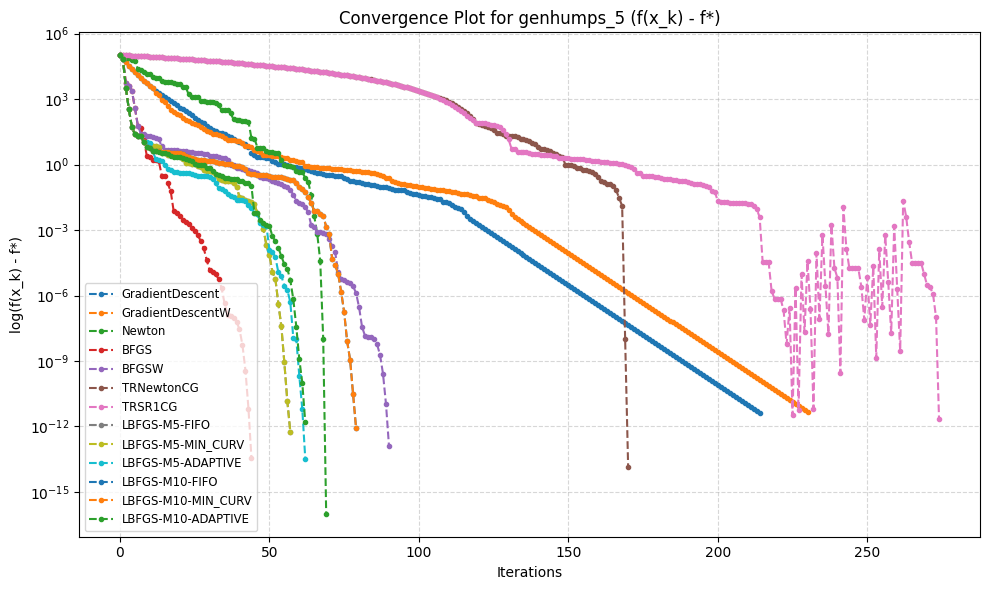

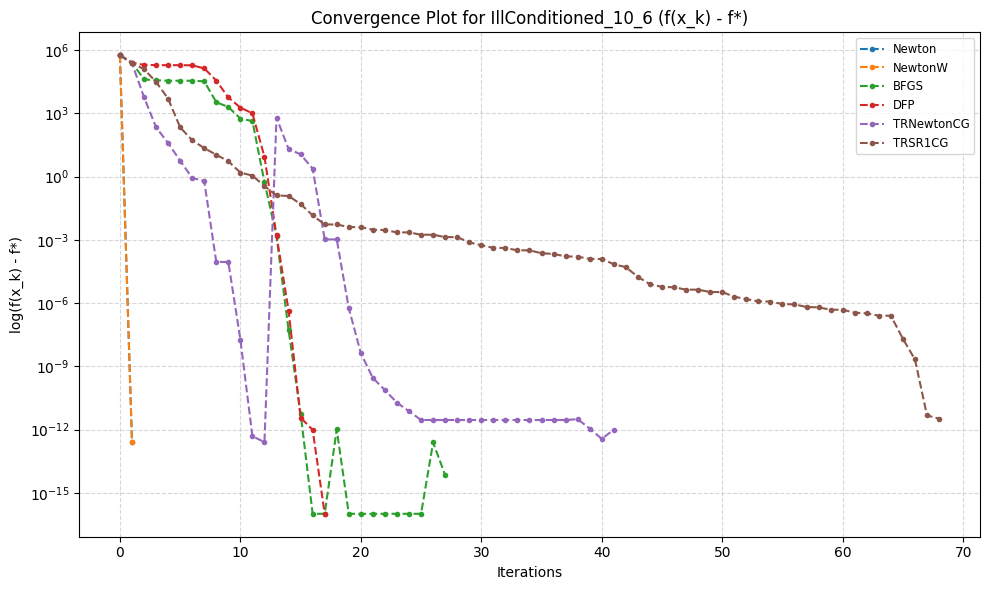

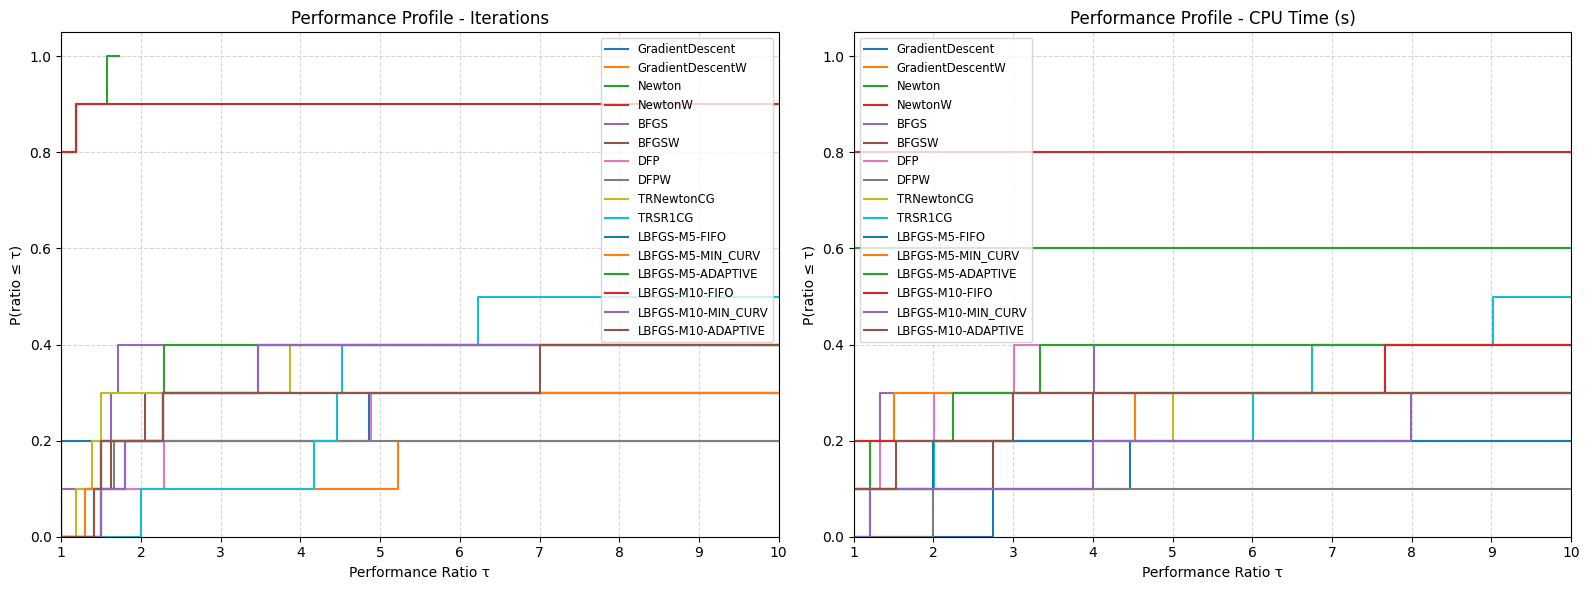

In [7]:
# --- Convergence Plots (Function Value Gap vs Iterations) --- [cite: 305]

for problem_name in detailed_info:
    plt.figure(figsize=(10, 6))
    plt.title(f"Convergence Plot for {problem_name} (f(x_k) - f*)")
    
    problem_has_gap = False
    for method_name, info in detailed_info[problem_name].items():
        if info.get('success', False) and 'f_gaps' in info and info['f_gaps']:
            # Plot only successful runs with f_gaps data
            iterations = range(len(info['f_gaps']))
            # Add a small epsilon to avoid log(0) issues
            f_gaps_plot = np.maximum(np.array(info['f_gaps']), 1e-16) 
            plt.plot(iterations, f_gaps_plot, label=method_name, marker='o', markersize=3, linestyle='--')
            problem_has_gap = True
        elif info.get('success', False) and 'f_values' in info and info['f_values']:
            # Plot f_values if f_gaps is not available (but warn)
            print(f"Note: Plotting f(x_k) for {method_name} on {problem_name} as f* is unavailable.")
            iterations = range(len(info['f_values']))
            f_values_plot = np.array(info['f_values'])
            plt.plot(iterations, f_values_plot, label=f"{method_name} (f(x))", marker='x', markersize=3, linestyle=':')
        
    if problem_has_gap:
        plt.yscale('log')
        plt.ylabel('log(f(x_k) - f*)')
    else:
         plt.ylabel('f(x_k)') # Label appropriately if plotting raw function values

        
    plt.xlabel('Iterations')
    plt.grid(True, which="both", ls="--", alpha=0.5)
    plt.legend(fontsize='small')
    plt.tight_layout()
    plt.show()

# --- Performance Profiles --- [cite: 305]
# (Using a simplified version based on iterations and time)

def plot_performance_profile(metric_data, metric_name, ax):
    "Helper to plot a single performance profile."
    max_ratio = 0 # Track max ratio for plot limits
    num_problems = 0
    if metric_data:
        num_problems = len(next(iter(metric_data.values()))) # Get number of problems from first method

    for method, ratios in metric_data.items():
        valid_ratios = [r for r in ratios if np.isfinite(r)]
        if not valid_ratios: continue
        
        sorted_ratios = np.sort(valid_ratios)
        y = np.arange(1, len(sorted_ratios) + 1) / num_problems # Normalize by total problems
        
        # Extend the line for step plot visualization
        plot_x = np.concatenate(([1], sorted_ratios, [sorted_ratios[-1]*1.1])) # Start at 1, include points, extend slightly
        plot_y = np.concatenate(([0], y, [y[-1]])) # Step plot y-coordinates
        
        ax.step(plot_x, plot_y, where='post', label=method)
        max_ratio = max(max_ratio, sorted_ratios[-1] if sorted_ratios.size > 0 else 1)
        
    ax.set_title(f'Performance Profile - {metric_name}')
    ax.set_xlabel('Performance Ratio τ')
    ax.set_ylabel('P(ratio ≤ τ)')
    ax.grid(True, which="both", ls="--", alpha=0.5)
    ax.legend(fontsize='small')
    # Set x-limits dynamically, but with a reasonable upper bound
    ax.set_xlim(1, max(2, min(10, max_ratio * 1.1))) 
    ax.set_ylim(0, 1.05)

# --- Calculate Performance Ratios --- 
perf_ratios = {'Iterations': {}, 'CPU Time (s)': {}}
problems_list = list(results.keys())
methods_list = [m['name'] for m in method_specs]

for metric in perf_ratios.keys():
    min_perf = {}
    for prob_name in problems_list:
        min_val = float('inf')
        for meth_name in methods_list:
            # Check if results exist for this problem/method combo
            res = results.get(prob_name, {}).get(meth_name, {})
            val = res.get(metric, float('inf'))
            if isinstance(val, (int, float)) and np.isfinite(val) and res.get('Success', False):
                 # Only consider successful runs for minimum performance
                min_val = min(min_val, val)
        min_perf[prob_name] = min_val if np.isfinite(min_val) else 1.0 # Avoid division by zero/inf
        if min_perf[prob_name] == 0 : min_perf[prob_name] = 1e-10 # Avoid division by exactly zero

    for meth_name in methods_list:
        ratios_list = []
        for prob_name in problems_list:
            res = results.get(prob_name, {}).get(meth_name, {})
            val = res.get(metric, float('inf'))
            if isinstance(val, (int, float)) and np.isfinite(val) and res.get('Success', False):
                 ratio = val / min_perf[prob_name]
                 # Cap ratio at a large number if method was very slow compared to best
                 ratios_list.append(min(ratio, 20)) # Cap ratio at 20 for plotting
            else:
                 ratios_list.append(20) # Assign high ratio for failures or non-finite values
        perf_ratios[metric][meth_name] = ratios_list

# --- Plot Profiles --- 
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

if perf_ratios['Iterations']:
    plot_performance_profile(perf_ratios['Iterations'], 'Iterations', axes[0])
else:
    axes[0].set_title('Performance Profile - Iterations (No Data)')

if perf_ratios['CPU Time (s)']:
    plot_performance_profile(perf_ratios['CPU Time (s)'], 'CPU Time (s)', axes[1])
else:
    axes[1].set_title('Performance Profile - CPU Time (s) (No Data)')

plt.tight_layout()
plt.show()